## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.Transformer import *

In [2]:
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(109)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [5]:
size = 44
batch_size = 256
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [6]:
root = 'df_224/train'
train_data = create_dataset(root, transformation)
sampler = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler=sampler)

In [7]:
root = 'df_224/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [8]:
root = 'df_224/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[65786, 34145, 2128, 48179, 73120, 27766, 51755, 8697, 881]


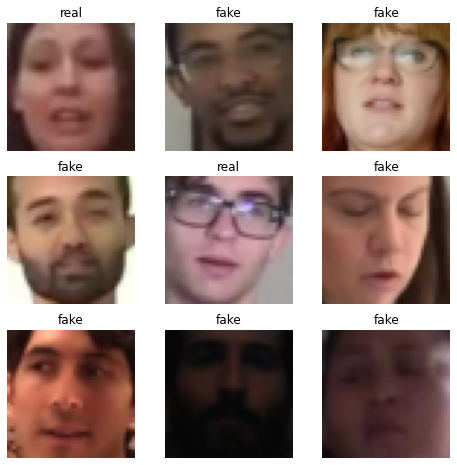

In [9]:
visualize_data(train_data)

[8721, 1562, 4183, 9547, 3273, 6812, 8118, 6757, 199]


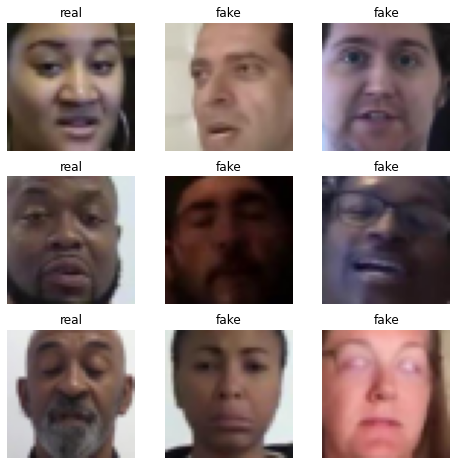

In [10]:
visualize_data(test_data)

## Initialize Model

In [11]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [12]:
from math import floor
# number of convolutional 'embedding' layers and their sizes
hidden = [3, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of avgpooling layer
window = 4

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

In [13]:
model = Transformer(hidden, kernel_size, window, blocks).to(device)
print(model)

Transformer(
  (conv_combined): Sequential(
    (0): ConvEmbed(
      (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): ConvEmbed(
      (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): ConvEmbed(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (avgpool): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (blocks_combined): Sequential(
    (0): TransformerBlock(
      (attention): AttentionLayer(
        (query): Linear(in_features=2592, out_features=2592, bias=True)
       

## Training Model

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [15]:
optimizer = create_adam_optimizer(model, lr = 0.001)

In [26]:
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20, patience=5)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.5390625
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.5872395833333334
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.5841619318181818
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.576416015625
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.5721726190476191
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.5707632211538461
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.5699344758064516
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.5691189236111112
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.5720274390243902
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.5690387228260869
Epoch 1/20, Batch number: 50, Cumulated accuracy: 0.5693933823529411
Epoch 1/20, Batch number: 55, Cumulated accuracy: 0.5675223214285714
Epoch 1/20, Batch number: 60, Cumulated accuracy: 0.5682633196721312
Epoch 1/20, Batch number: 65, Cumulated accuracy: 0.5670572916666666
Epoch 1/20, Batch number: 70, Cumulated accuracy:

Epoch 2/20, Batch number: 285, Cumulated accuracy: 0.572265625
Epoch 2/20, Batch number: 290, Cumulated accuracy: 0.5722857603092784
Epoch 2/20, Batch number: 295, Cumulated accuracy: 0.5719620988175675
--- Epoch 2/20: Train loss: 0.6740, Train accuracy: 0.5721
--- Epoch 2/20: Val loss: 0.6750, Val accuracy: 0.6160
Epoch 3/20, Batch number: 0, Cumulated accuracy: 0.59765625
Epoch 3/20, Batch number: 5, Cumulated accuracy: 0.5826822916666666
Epoch 3/20, Batch number: 10, Cumulated accuracy: 0.5791903409090909
Epoch 3/20, Batch number: 15, Cumulated accuracy: 0.5849609375
Epoch 3/20, Batch number: 20, Cumulated accuracy: 0.5760788690476191
Epoch 3/20, Batch number: 25, Cumulated accuracy: 0.5707632211538461
Epoch 3/20, Batch number: 30, Cumulated accuracy: 0.5748487903225806
Epoch 3/20, Batch number: 35, Cumulated accuracy: 0.5750868055555556
Epoch 3/20, Batch number: 40, Cumulated accuracy: 0.5779344512195121
Epoch 3/20, Batch number: 45, Cumulated accuracy: 0.5795686141304348
Epoch 3/2

Epoch 4/20, Batch number: 265, Cumulated accuracy: 0.5763334116541353
Epoch 4/20, Batch number: 270, Cumulated accuracy: 0.5762223247232472
Epoch 4/20, Batch number: 275, Cumulated accuracy: 0.5766106204710145
Epoch 4/20, Batch number: 280, Cumulated accuracy: 0.5765402580071174
Epoch 4/20, Batch number: 285, Cumulated accuracy: 0.5764040646853147
Epoch 4/20, Batch number: 290, Cumulated accuracy: 0.5762188573883161
Epoch 4/20, Batch number: 295, Cumulated accuracy: 0.5762378589527027
--- Epoch 4/20: Train loss: 0.6725, Train accuracy: 0.5765
--- Epoch 4/20: Val loss: 0.7141, Val accuracy: 0.4835
Epoch 5/20, Batch number: 0, Cumulated accuracy: 0.609375
Epoch 5/20, Batch number: 5, Cumulated accuracy: 0.5970052083333334
Epoch 5/20, Batch number: 10, Cumulated accuracy: 0.5827414772727273
Epoch 5/20, Batch number: 15, Cumulated accuracy: 0.583740234375
Epoch 5/20, Batch number: 20, Cumulated accuracy: 0.5803571428571429
Epoch 5/20, Batch number: 25, Cumulated accuracy: 0.583082932692307

Epoch 6/20, Batch number: 245, Cumulated accuracy: 0.58203125
Epoch 6/20, Batch number: 250, Cumulated accuracy: 0.5822491284860558
Epoch 6/20, Batch number: 255, Cumulated accuracy: 0.582122802734375
Epoch 6/20, Batch number: 260, Cumulated accuracy: 0.5817468869731801
Epoch 6/20, Batch number: 265, Cumulated accuracy: 0.5814732142857143
Epoch 6/20, Batch number: 270, Cumulated accuracy: 0.5815411669741697
Epoch 6/20, Batch number: 275, Cumulated accuracy: 0.581450973731884
Epoch 6/20, Batch number: 280, Cumulated accuracy: 0.5813083852313167
Epoch 6/20, Batch number: 285, Cumulated accuracy: 0.5816761363636364
Epoch 6/20, Batch number: 290, Cumulated accuracy: 0.5813198024054983
Epoch 6/20, Batch number: 295, Cumulated accuracy: 0.5811206714527027
--- Epoch 6/20: Train loss: 0.6694, Train accuracy: 0.5812
--- Epoch 6/20: Val loss: 0.6505, Val accuracy: 0.6946
Epoch 7/20, Batch number: 0, Cumulated accuracy: 0.63671875
Epoch 7/20, Batch number: 5, Cumulated accuracy: 0.585286458333333

Epoch 8/20, Batch number: 225, Cumulated accuracy: 0.5824287887168141
Epoch 8/20, Batch number: 230, Cumulated accuracy: 0.5825047348484849
Epoch 8/20, Batch number: 235, Cumulated accuracy: 0.5826436705508474
Epoch 8/20, Batch number: 240, Cumulated accuracy: 0.5831334284232366
Epoch 8/20, Batch number: 245, Cumulated accuracy: 0.5832698170731707
Epoch 8/20, Batch number: 250, Cumulated accuracy: 0.5832607071713147
Epoch 8/20, Batch number: 255, Cumulated accuracy: 0.5841217041015625
Epoch 8/20, Batch number: 260, Cumulated accuracy: 0.5839768917624522
Epoch 8/20, Batch number: 265, Cumulated accuracy: 0.5841165413533834
Epoch 8/20, Batch number: 270, Cumulated accuracy: 0.584640221402214
Epoch 8/20, Batch number: 275, Cumulated accuracy: 0.5846920289855072
Epoch 8/20, Batch number: 280, Cumulated accuracy: 0.5847419928825622
Epoch 8/20, Batch number: 285, Cumulated accuracy: 0.5846946022727273
Epoch 8/20, Batch number: 290, Cumulated accuracy: 0.5848099226804123
Epoch 8/20, Batch num

Epoch 10/20, Batch number: 200, Cumulated accuracy: 0.5874144900497512
Epoch 10/20, Batch number: 205, Cumulated accuracy: 0.5878716626213593
Epoch 10/20, Batch number: 210, Cumulated accuracy: 0.5871778732227488
Epoch 10/20, Batch number: 215, Cumulated accuracy: 0.5873661747685185
Epoch 10/20, Batch number: 220, Cumulated accuracy: 0.5877050339366516
Epoch 10/20, Batch number: 225, Cumulated accuracy: 0.5873548119469026
Epoch 10/20, Batch number: 230, Cumulated accuracy: 0.5872734036796536
Epoch 10/20, Batch number: 235, Cumulated accuracy: 0.5874106197033898
Epoch 10/20, Batch number: 240, Cumulated accuracy: 0.5880932313278008
Epoch 10/20, Batch number: 245, Cumulated accuracy: 0.5880811737804879
Epoch 10/20, Batch number: 250, Cumulated accuracy: 0.5880540338645418
Epoch 10/20, Batch number: 255, Cumulated accuracy: 0.588592529296875
Epoch 10/20, Batch number: 260, Cumulated accuracy: 0.5891552921455939
Epoch 10/20, Batch number: 265, Cumulated accuracy: 0.5890654370300752
Epoch 1

Epoch 12/20, Batch number: 170, Cumulated accuracy: 0.5908031798245614
Epoch 12/20, Batch number: 175, Cumulated accuracy: 0.5907981178977273
Epoch 12/20, Batch number: 180, Cumulated accuracy: 0.5904264502762431
Epoch 12/20, Batch number: 185, Cumulated accuracy: 0.5905997983870968
Epoch 12/20, Batch number: 190, Cumulated accuracy: 0.5897414921465969
Epoch 12/20, Batch number: 195, Cumulated accuracy: 0.590202487244898
Epoch 12/20, Batch number: 200, Cumulated accuracy: 0.589804881840796
Epoch 12/20, Batch number: 205, Cumulated accuracy: 0.5898627123786407
Epoch 12/20, Batch number: 210, Cumulated accuracy: 0.5896586196682464
Epoch 12/20, Batch number: 215, Cumulated accuracy: 0.5897714120370371
Epoch 12/20, Batch number: 220, Cumulated accuracy: 0.5894902432126696
Epoch 12/20, Batch number: 225, Cumulated accuracy: 0.5902585730088495
Epoch 12/20, Batch number: 230, Cumulated accuracy: 0.5903510551948052
Epoch 12/20, Batch number: 235, Cumulated accuracy: 0.5906382415254238
Epoch 12

## Testing Model & Performance Curves

In [27]:
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.6303, Test accuracy: 0.7348


Precision: 0.3225048923679061
Recall: 0.5058317986494782
F1 score: 0.39388145315487566


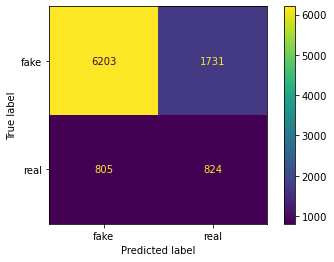

In [28]:
show_metrics(true_labels, model_preds)

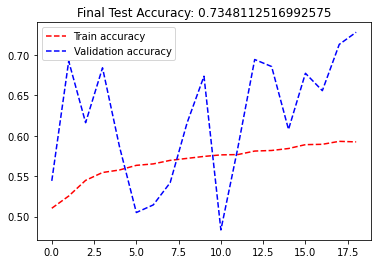

In [29]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

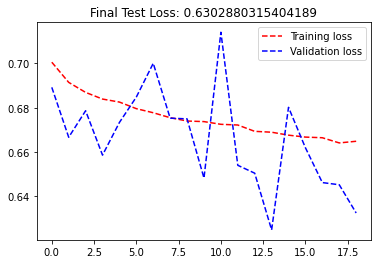

In [30]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [31]:
test_loader2 = produce_loader(test_data, 1)

In [32]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.3227450980392157
Recall: 0.5052179251074279
F1 score: 0.3938741325675999


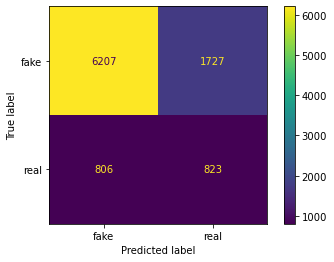

In [33]:
show_metrics(true_labels2, model_preds2)

[760, 6389, 4831, 6901, 1048, 995, 5925, 6670, 6460, 805, 3094, 3904, 5348, 4857, 1804, 4150, 923, 6873, 3795, 5498, 5792, 4251, 3407, 2198, 6879]


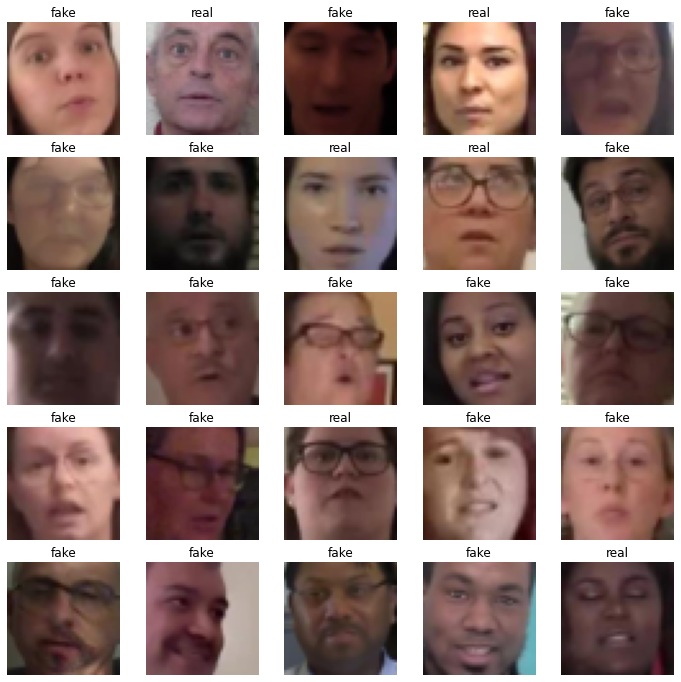

In [34]:
visualize_data(correct_list, (12,12), 5)

[1125, 915, 1181, 33, 1973, 1707, 151, 2107, 488, 1182, 757, 1846, 589, 432, 917, 530, 246, 1419, 858, 1861, 683, 2197, 186, 1713, 844]


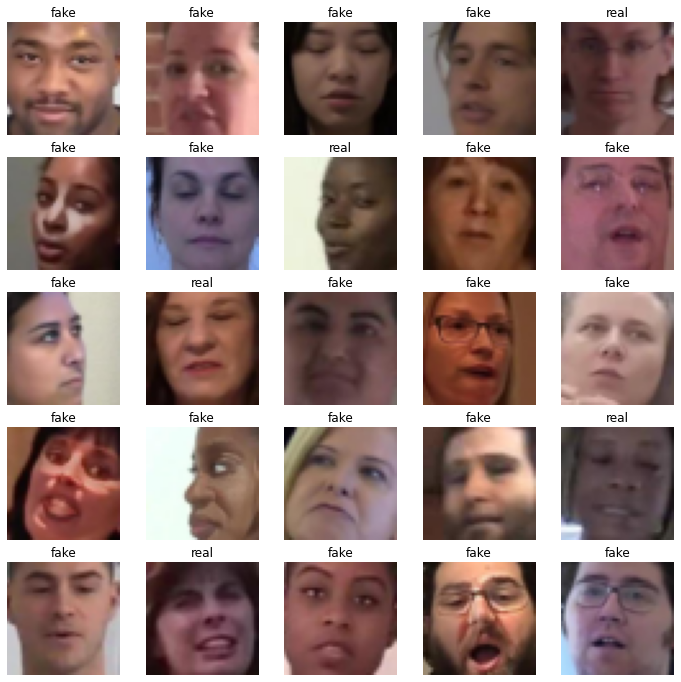

In [35]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

In [36]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './transformer_19epochs')